In [86]:
!pip install torch_geometric

In [41]:
pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=7cebb339e9406e7b4c524e49a55d572309e4564ee138d617d7340e466c9d87fb
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1158903 sha256=21f15195d4e8aaf50002af12f3e4d4f7727968d637ab1431c1fcecf4788b2292
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2
  Created wheel for torch-

In [42]:
import pandas as pd
import h5py
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
import gzip

In [43]:
link_path = "9606.protein.links.detailed.v12.0.txt.gz"
protein_path = "9606.protein.info.v12.0.txt.gz"
embedded_path = "9606.protein.network.embeddings.v12.0.h5"

In [44]:
evidence_cols = [
    "neighborhood", "fusion", "cooccurence", "coexpression",
    "experimental", "database", "textmining"
]

In [45]:
edges_df = pd.read_csv("9606.protein.links.detailed.v12.0.txt.gz", sep=r'\s+', header=0)
edges_df = edges_df[edges_df["combined_score"] >= 700]

In [46]:
with gzip.open(protein_path, "rt") as f:
  df_proteins = pd.read_csv(f, sep="\t")
display(df_proteins.head())

,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,"Peptidyl-prolyl cis-trans isomerase FKBP4, N-t..."
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."


In [80]:
with h5py.File(embedded_path, "r") as f:
    def print_structure(name, obj):
        print(name)

    print("Available HDF5 groups and datasets:")
    f.visititems(print_structure)

Available HDF5 groups and datasets:
embeddings
metadata
proteins


In [81]:
with h5py.File(embedded_path, "r") as f:
  embeddings = f["embeddings"][:]
  protein_ids = [p.decode("utf-8") for p in f["proteins"][:]]
df_embedded = pd.DataFrame(embeddings, index=protein_ids)
df_embedded["protein"] = protein_ids

In [82]:
print(df_proteins.columns)

Index(['#string_protein_id', 'preferred_name', 'protein_size', 'annotation'], dtype='object')


In [83]:
df_info_embedded = pd.merge(df_proteins, df_embedded, how="inner", left_on = "#string_protein_id", right_on="protein")
display(df_info_embedded.head())

,#string_protein_id,preferred_name,protein_size,annotation,0,1,2,3,4,5,...,503,504,505,506,507,508,509,510,511,protein
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,-0.045654,-0.051727,-0.080566,0.016968,0.005512,0.002977,...,-0.015869,0.013252,-0.013992,0.027161,-0.007957,0.041931,-0.008659,0.009865,0.011772,9606.ENSP00000000233
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...,-0.002146,-0.046967,-0.053741,0.021332,0.017822,0.033752,...,0.005398,-0.041656,0.004196,-0.065857,-0.011673,0.015930,-0.020996,0.027481,0.010063,9606.ENSP00000000412
2,9606.ENSP00000001008,FKBP4,459,"Peptidyl-prolyl cis-trans isomerase FKBP4, N-t...",0.061035,0.003860,0.018433,0.004105,-0.047424,-0.035156,...,0.020187,0.005020,0.006550,-0.029694,-0.006809,-0.028046,-0.009026,0.001847,0.025513,9606.ENSP00000001008
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...,-0.027298,-0.046661,0.030777,0.026093,0.002377,0.001459,...,0.001358,0.041809,-0.035980,0.059479,-0.022842,-0.035950,0.012070,-0.000162,0.013023,9606.ENSP00000001146
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi...",-0.001792,0.001739,-0.008293,-0.005833,0.063904,-0.011513,...,0.013466,0.006973,0.031860,-0.036621,0.026703,-0.031891,-0.001738,0.027191,0.035980,9606.ENSP00000002125


In [84]:
print(df_info_embedded.columns.tolist())


['#string_protein_id', 'preferred_name', 'protein_size', 'annotation', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,

In [85]:
df_merged = edges_df.merge(
    df_info_embedded, how="left",
    left_on="protein1", right_on="protein", suffixes=("", "_1")
)
df_merged = df_merged.rename(columns={
    'preferred_name': 'preferred_name_1',
    'protein_size': 'protein_size_1',
    'annotation': 'annotation_1'
})
df_merged = df_merged.merge(
    df_info_embedded, how="left",
    left_on="protein2", right_on="protein", suffixes=("", "_2")
)
df_merged = df_merged.rename(columns={
    'preferred_name': 'preferred_name_2',
    'protein_size': 'protein_size_2',
    'annotation': 'annotation_2'
})

In [53]:
node1_cols_merged = ['preferred_name_1', 'protein_size_1', 'annotation_1']
node2_cols_merged = ['preferred_name_2', 'protein_size_2', 'annotation_2']
evidence_cols = ["neighborhood", "fusion", "cooccurence", "coexpression", "experimental", "database", "textmining"]
df_final = df_merged[
    ["protein1", "protein2", "combined_score"] +
    node1_cols_merged +
    node2_cols_merged +
    evidence_cols +
    ["protein"]
]
df_final.head(10)

,protein1,protein2,combined_score,preferred_name_1,protein_size_1,annotation_1,preferred_name_2,protein_size_2,annotation_2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,protein
0,9606.ENSP00000000233,9606.ENSP00000158762,825,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,ACAP1,740,"Arf-GAP with coiled-coil, ANK repeat and PH do...",0,0,0,47,91,0,814,9606.ENSP00000000233
1,9606.ENSP00000000233,9606.ENSP00000357048,718,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,COPA,1233,Coatomer subunit alpha; The coatomer is a cyto...,0,0,0,79,271,500,260,9606.ENSP00000000233
2,9606.ENSP00000000233,9606.ENSP00000262305,952,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,RAB11FIP3,756,Rab11 family-interacting protein 3; Acts as a ...,0,0,0,0,663,0,866,9606.ENSP00000000233
3,9606.ENSP00000000233,9606.ENSP00000329419,752,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,COPB2,906,Coatomer subunit beta; The coatomer is a cytos...,0,0,0,89,298,500,316,9606.ENSP00000000233
4,9606.ENSP00000000233,9606.ENSP00000469035,795,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,COPE,331,Coatomer subunit epsilon; The coatomer is a cy...,0,0,0,335,268,500,259,9606.ENSP00000000233
5,9606.ENSP00000000233,9606.ENSP00000256682,756,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,ARF3,181,ADP-ribosylation factor 3; GTP-binding protein...,0,0,0,128,477,500,60,9606.ENSP00000000233
6,9606.ENSP00000000233,9606.ENSP00000314615,795,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,ARFGAP1,414,ADP-ribosylation factor GTPase-activating prot...,0,0,0,88,288,500,445,9606.ENSP00000000233
7,9606.ENSP00000000233,9606.ENSP00000331342,755,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,RAB11FIP1,1283,Rab11 family-interacting protein 1; A Rab11 ef...,0,0,0,56,102,0,735,9606.ENSP00000000233
8,9606.ENSP00000000233,9606.ENSP00000389095,765,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,CYTH1,398,Cytohesin-1; Promotes guanine-nucleotide excha...,0,0,0,47,53,0,761,9606.ENSP00000000233
9,9606.ENSP00000000233,9606.ENSP00000480301,835,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,IQSEC1,1114,IQ motif and SEC7 domain-containing protein 1;...,0,0,0,49,62,0,830,9606.ENSP00000000233


In [54]:
import matplotlib.pyplot as plt

In [55]:
G = nx.from_pandas_edgelist(
    df_final,
    source="protein1",
    target="protein2",
    edge_attr=["combined_score"] + evidence_cols
)

In [56]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 16201
Number of edges: 236930


In [57]:
if G.number_of_edges() == 0:
    raise ValueError("No edges found! Try lowering combined_score threshold.")

In [58]:
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc).copy()

In [59]:
if H.number_of_nodes() > 50:
    H = nx.subgraph(H, list(list(H.nodes())[:50]))

In [60]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(H, seed=42)

<Figure size 1200x800 with 0 Axes>

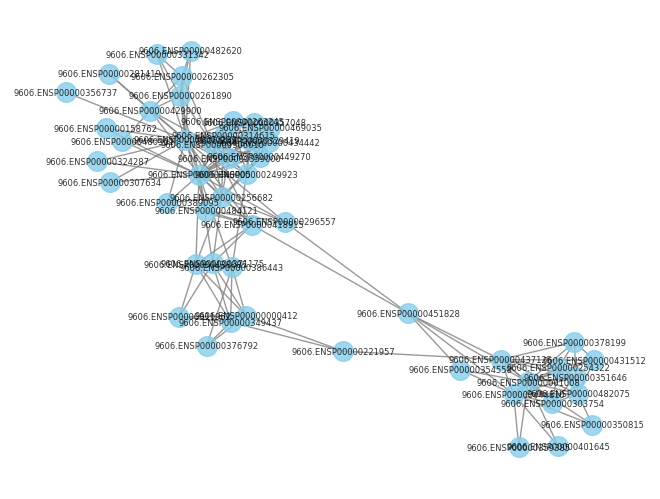

In [61]:
nx.draw(
    H, pos,
    with_labels=True,
    node_size=200,
    node_color="skyblue",
    font_size=6,
    edge_color="gray",
    alpha=0.8
)

In [62]:
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.utils import from_networkx, to_networkx
import warnings
warnings.filterwarnings('ignore')

In [63]:
torch.manual_seed(42)
np.random.seed(42)

In [64]:
print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


In [65]:
import networkx as nx
import matplotlib.pyplot as plt

In [66]:
import networkx as nx

# Initialize the undirected graph
G = nx.Graph()

# --- Construct graph with node and edge attributes ---
for _, row in df_final.iterrows():
    # Add Protein 1 with metadata
    G.add_node(
        row["protein1"],
        preferred_name=row["preferred_name_1"],
        annotation=row["annotation_1"],
        size=row["protein_size_1"]
    )

    # Add Protein 2 with metadata
    G.add_node(
        row["protein2"],
        preferred_name=row["preferred_name_2"],
        annotation=row["annotation_2"],
        size=row["protein_size_2"]
    )

    # Add the interaction (edge) with multi-dimensional evidence
    G.add_edge(
        row["protein1"],
        row["protein2"],
        weight=row["combined_score"],
        coexpression=row["coexpression"],
        experimental=row["experimental"],
        database=row["database"],
        textmining=row["textmining"],
        neighborhood=row["neighborhood"],
        fusion=row["fusion"],
        cooccurence=row["cooccurence"] # Corrected typo here
    )

# --- Verification ---
print(f"Graph constructed with {G.number_of_nodes()} proteins and {G.number_of_edges()} interactions.\n")

# Example: Extract attributes for one protein
example_protein = list(G.nodes())[0]
print("Example Protein Node:", example_protein)
print("Attributes:", G.nodes[example_protein])

Graph constructed with 16201 proteins and 236930 interactions.

Example Protein Node: 9606.ENSP00000000233
Attributes: {'preferred_name': 'ARF5', 'annotation': 'ADP-ribosylation factor 5; GTP-binding protein involved in protein trafficking; may modulate vesicle budding and uncoating within the Golgi apparatus. Belongs to the small GTPase superfamily. Arf family.', 'size': 180}


In [67]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_ppi_graph(G, num_nodes=50, random_sample=True):
    """
    Visualize a subgraph of the Protein–Protein Interaction (PPI) graph.

    Parameters:
        G (networkx.Graph): The full PPI graph.
        num_nodes (int): Number of nodes to visualize in the subgraph.
        random_sample (bool): If True, sample random nodes.
                              If False, take the first `num_nodes`.
    """
    # Select nodes
    if random_sample:
        sub_nodes = random.sample(list(G.nodes()), min(num_nodes, len(G)))
    else:
        sub_nodes = list(G.nodes())[:num_nodes]

    # Create subgraph
    H = G.subgraph(sub_nodes)
    pos = nx.spring_layout(H, seed=42)

    # Scale node size by protein size (fallback to degree if missing)
    node_sizes = [
        G.nodes[n].get("protein_size", G.degree(n) * 10) * 2
        for n in H.nodes()
    ]

    # Scale edge width by combined_score (fallback = 1)
    edge_weights = [
        H[u][v].get("combined_score", 500) / 200
        for u, v in H.edges()
    ]

    # Plot
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(H, pos,
                           node_size=node_sizes,
                           node_color="skyblue",
                           alpha=0.8, edgecolors="black")

    nx.draw_networkx_edges(H, pos,
                           width=edge_weights,
                           alpha=0.6,
                           edge_color="gray")

    nx.draw_networkx_labels(H, pos,
                            labels={n: G.nodes[n].get("preferred_name", n) for n in H.nodes()},
                            font_size=8,
                            font_color="black")

    plt.title(f"Protein–Protein Interaction Subgraph ({len(H.nodes())} nodes)", fontsize=14)
    plt.axis("off")
    plt.show()

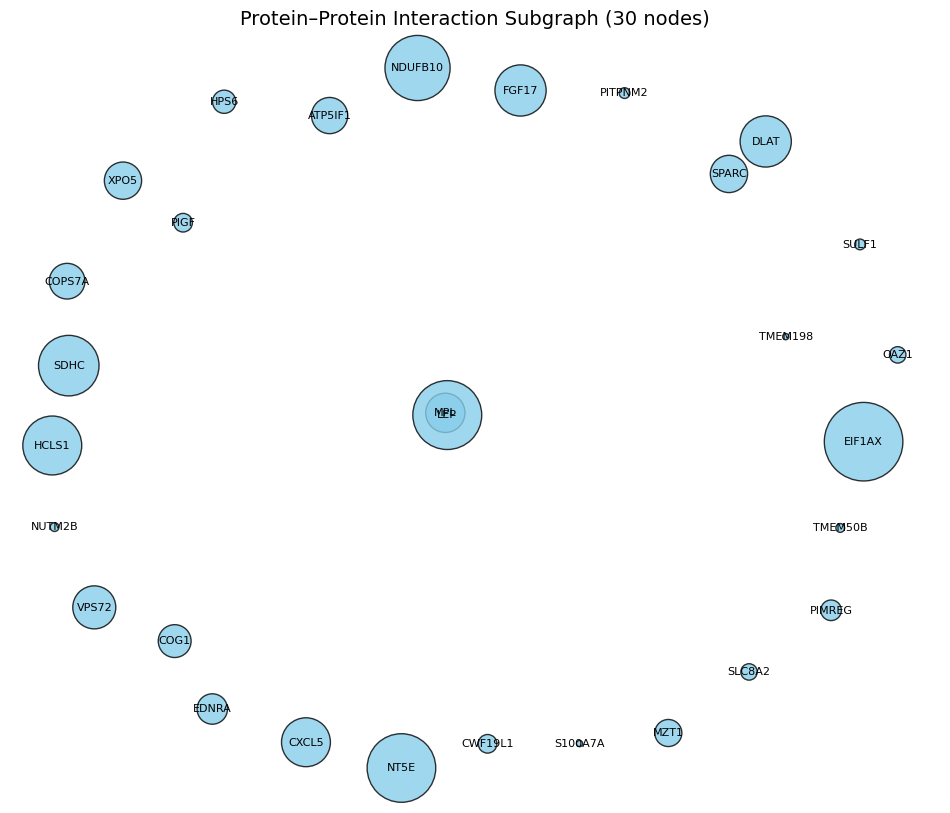

In [68]:
visualize_ppi_graph(G, num_nodes=30, random_sample=True)

In [69]:
import numpy as np

def add_node_embeddings(G, df_final):
    """
    Add embedding vectors as node attributes in the graph.

    Parameters:
        G (networkx.Graph): Protein interaction graph.
        df_final (pd.DataFrame): Final dataset with embeddings.
    """
    # Identify embedding columns
    embedding_cols = [col for col in df_final.columns if col.startswith("dim")]

    # Assign embeddings
    for _, row in df_final.iterrows():
        protein_id = row["protein"]
        if protein_id in G.nodes():
            G.nodes[protein_id]["embedding"] = row[embedding_cols].values.astype(float)

    print(f"✅ Added embeddings to {sum('embedding' in G.nodes[n] for n in G.nodes())} nodes.")
    return G


In [70]:
G = add_node_embeddings(G, df_final)


✅ Added embeddings to 16201 nodes.


In [87]:
def convert_to_pyg_data(df_final, embeddings_dict):
    import torch
    from torch_geometric.data import Data

    # Create mapping: protein → index
    proteins = sorted(set(df_final["protein1"]) | set(df_final["protein2"]))
    protein_to_idx = {p: i for i, p in enumerate(proteins)}

    # Build edge index
    edge_index = []
    for _, row in df_final.iterrows():
        edge_index.append([protein_to_idx[row["protein1"]], protein_to_idx[row["protein2"]]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Build node features (convert numpy → torch)
    features = []
    for p in proteins:
        emb = embeddings_dict.get(p)
        if emb is not None:
            features.append(torch.tensor(emb, dtype=torch.float))
        else:
            features.append(torch.zeros(128))  # fallback if embedding missing
    x = torch.stack(features)

    data = Data(x=x, edge_index=edge_index)
    return data, protein_to_idx


In [90]:
# Create embeddings dictionary from df_embedded
embeddings_dict = df_embedded.set_index('protein').T.to_dict('list')

# Convert list values to numpy arrays within the dictionary
embeddings_dict = {k: np.array(v) for k, v in embeddings_dict.items()}

data, protein_to_idx = convert_to_pyg_data(df_final, embeddings_dict)

print(data)
print("Node features shape:", data.x.shape)
print("Edges shape:", data.edge_index.shape)

Data(x=[16201, 512], edge_index=[2, 473860])
Node features shape: torch.Size([16201, 512])
Edges shape: torch.Size([2, 473860])


In [91]:
from sklearn.preprocessing import LabelEncoder

In [92]:
def prepare_node_classification(df_final, data, protein_to_idx):
    # Build labels using annotation_1 / annotation_2
    annotations = {}
    for _, row in df_final.iterrows():
        annotations[row["protein1"]] = row["annotation_1"]
        annotations[row["protein2"]] = row["annotation_2"]

    labels = []
    for p in protein_to_idx.keys():
        labels.append(annotations.get(p, "unknown"))

    le = LabelEncoder()
    y = torch.tensor(le.fit_transform(labels), dtype=torch.long)

    data.y = y
    return data, le

In [93]:
def prepare_link_prediction(data):
    # Positive edges
    pos_edge_index = data.edge_index

    # Negative edges (randomly sampled non-edges)
    num_nodes = data.num_nodes
    neg_edges = []
    existing = set(map(tuple, pos_edge_index.t().tolist()))

    np.random.seed(42)
    while len(neg_edges) < pos_edge_index.shape[1]:
        i, j = np.random.randint(0, num_nodes, 2)
        if i != j and (i, j) not in existing and (j, i) not in existing:
            neg_edges.append([i, j])

    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t()

    return pos_edge_index, neg_edge_index

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# ------------------------
# 1. Define GAT model
# ------------------------
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # node embeddings or logits


In [95]:
# ------------------------
# 2. Training & evaluation
# ------------------------
def train(model, optimizer, data, device):
    model.train()
    optimizer.zero_grad()

    out = model(data.x.to(device), data.edge_index.to(device))

    # 🔹 Dummy task: pretend we have N classes and assign random labels
    num_nodes = data.num_nodes
    num_classes = out.size(1)
    target = torch.randint(0, num_classes, (num_nodes,), device=device)

    loss = F.cross_entropy(out, target)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, device):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    return out  # embeddings/logits


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = data.num_node_features
hidden_channels = 64
out_channels = 16   # keep it small for now

model = GATModel(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

print("Starting training...")
for epoch in range(1, 51):
    loss = train(model, optimizer, data, device)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")

# Extract final embeddings
embeddings = evaluate(model, data, device)
print("Embeddings shape:", embeddings.shape)

Starting training...
Epoch 05, Loss: 2.7744
Epoch 10, Loss: 2.7741
Epoch 15, Loss: 2.7733
Epoch 20, Loss: 2.7734
Epoch 25, Loss: 2.7734
Epoch 30, Loss: 2.7737
Epoch 35, Loss: 2.7732
Epoch 40, Loss: 2.7732
Epoch 45, Loss: 2.7730
Epoch 50, Loss: 2.7729
Embeddings shape: torch.Size([16201, 16])


In [97]:
from torch_geometric.utils import train_test_split_edges

# Make a copy so we don't overwrite the original graph
link_data = data.clone()

# This adds train/val/test edge splits (with negatives)
link_data = train_test_split_edges(link_data)

print("Train edges:", link_data.train_pos_edge_index.size(1))
print("Val edges:", link_data.val_pos_edge_index.size(1))
print("Test edges:", link_data.test_pos_edge_index.size(1))


Train edges: 402782
Val edges: 11846
Test edges: 23693


In [98]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GATEncoder, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

In [99]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, encoder):
        super(LinkPredictor, self).__init__()
        self.encoder = encoder

    def decode(self, z, edge_index):
        # Dot product decoder
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index, pos_edge_index, neg_edge_index):
        z = self.encoder(x, edge_index)

        # Positive edges
        pos_out = self.decode(z, pos_edge_index)
        pos_label = torch.ones(pos_out.size(0), device=z.device)

        # Negative edges
        neg_out = self.decode(z, neg_edge_index)
        neg_label = torch.zeros(neg_out.size(0), device=z.device)

        out = torch.cat([pos_out, neg_out], dim=0)
        labels = torch.cat([pos_label, neg_label], dim=0)
        return out, labels

In [100]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = GATEncoder(in_channels=data.num_features,
                     hidden_channels=64,
                     out_channels=32).to(device)
model = LinkPredictor(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

x, edge_index = link_data.x.to(device), link_data.train_pos_edge_index.to(device)

In [101]:
def get_neg_edges(edge_index, num_nodes, num_neg_samples):
    return negative_sampling(edge_index=edge_index,
                             num_nodes=num_nodes,
                             num_neg_samples=num_neg_samples)

In [102]:
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()

    neg_edge_index = get_neg_edges(edge_index, link_data.num_nodes,
                                   link_data.train_pos_edge_index.size(1))

    out, labels = model(x, edge_index,
                        link_data.train_pos_edge_index.to(device),
                        neg_edge_index.to(device))

    loss = F.binary_cross_entropy_with_logits(out, labels)
    loss.backward()
    optimizer.step()

    # Validation AUC
    model.eval()
    with torch.no_grad():
        neg_val = get_neg_edges(link_data.val_pos_edge_index, link_data.num_nodes,
                                link_data.val_pos_edge_index.size(1))
        val_out, val_labels = model(x, edge_index,
                                    link_data.val_pos_edge_index.to(device),
                                    neg_val.to(device))
        val_auc = roc_auc_score(val_labels.cpu(),
                                torch.sigmoid(val_out).cpu())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Val AUC: {val_auc:.4f}")

Epoch 005, Loss: 0.5347, Val AUC: 0.8652
Epoch 010, Loss: 0.5040, Val AUC: 0.8992
Epoch 015, Loss: 0.4849, Val AUC: 0.9158
Epoch 020, Loss: 0.4745, Val AUC: 0.9262
Epoch 025, Loss: 0.4652, Val AUC: 0.9323
Epoch 030, Loss: 0.4614, Val AUC: 0.9366
Epoch 035, Loss: 0.4550, Val AUC: 0.9406
Epoch 040, Loss: 0.4518, Val AUC: 0.9435
Epoch 045, Loss: 0.4490, Val AUC: 0.9433
Epoch 050, Loss: 0.4461, Val AUC: 0.9447


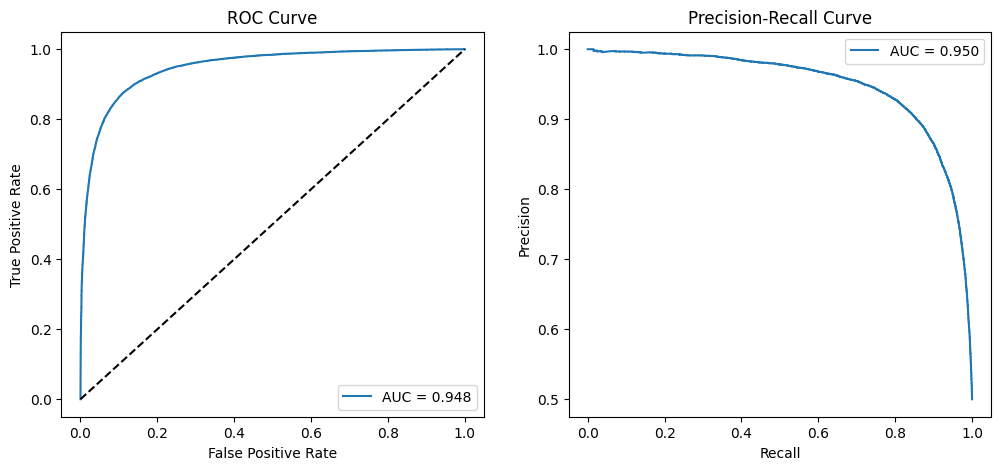

Test ROC AUC: 0.9484
Test PR AUC:  0.9497


In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

def evaluate_test(model, link_data, x, edge_index):
    model.eval()
    with torch.no_grad():
        # Generate negatives same size as positives
        neg_test = negative_sampling(
            edge_index=edge_index,
            num_nodes=link_data.num_nodes,
            num_neg_samples=link_data.test_pos_edge_index.size(1)
        ).to(device)

        out, labels = model(
            x, edge_index,
            link_data.test_pos_edge_index.to(device),
            neg_test
        )

        probs = torch.sigmoid(out).cpu().numpy()
        labels = labels.cpu().numpy()

        # ROC
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = roc_auc_score(labels, probs)

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(labels, probs)
        pr_auc = auc(recall, precision)

        # Plot ROC
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()

        # Plot Precision-Recall
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()

        plt.show()

        print(f"Test ROC AUC: {roc_auc:.4f}")
        print(f"Test PR AUC:  {pr_auc:.4f}")

# Call after training
evaluate_test(model, link_data, x, edge_index)


In [104]:
model.eval()
with torch.no_grad():
    z = model.encoder(x, edge_index)   # (num_nodes, embedding_dim)

print("Embedding matrix shape:", z.shape)


Embedding matrix shape: torch.Size([16201, 32])


In [105]:
import numpy as np

embeddings_np = z.cpu().numpy()

In [106]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)  # you can tune cluster number
clusters = kmeans.fit_predict(embeddings_np)

print("Cluster assignments (first 20):", clusters[:20])

Cluster assignments (first 20): [8 8 3 1 3 1 0 7 4 1 3 1 3 1 0 4 4 4 3 7]


In [120]:
from sklearn.cluster import KMeans
import joblib

# Train clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(z)

# Save the trained model
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']

In [121]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=10, affinity="nearest_neighbors", random_state=42)
clusters_spec = spectral.fit_predict(embeddings_np)

In [122]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_db = dbscan.fit_predict(embeddings_np)

In [123]:
import pandas as pd

protein_list = list(protein_to_idx.keys())
df_clusters = pd.DataFrame({
    "protein": protein_list,
    "kmeans_cluster": clusters,
    "spectral_cluster": clusters_spec,
    "dbscan_cluster": clusters_db
})

print(df_clusters.head())

                protein  kmeans_cluster  spectral_cluster  dbscan_cluster
0  9606.ENSP00000000233               8                 1               0
1  9606.ENSP00000000412               8                 1               0
2  9606.ENSP00000001008               3                 1               0
3  9606.ENSP00000001146               1                 1               0
4  9606.ENSP00000002125               3                 8               0


In [111]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.1 MB/s eta 0:00:00


In [124]:
from Bio.KEGG import REST

In [125]:
def fetch_kegg_pathway_genes(org="hsa"):
    lines = REST.kegg_list("pathway", org).read().strip().split("\n")
    pathway_ids = [l.split("\t")[0] for l in lines]
    pw_genes = {}
    for pw in pathway_ids:
        data = REST.kegg_get(pw).read().split("\n")
        genes = []
        section = None
        for ln in data:
            if ln.startswith("GENE"):
                section = "GENE"
                parts = ln[12:].split(";")
                gene_id = parts[0].split()[1] if parts and " " in parts[0] else parts[0]
                genes.append(gene_id)
            elif section and not ln.startswith(" "):
                section = None
        pw_genes[pw] = genes
    return pw_genes

In [114]:
kegg_pw_genes = fetch_kegg_pathway_genes()
print(f"Fetched {len(kegg_pw_genes)} KEGG pathways with genes")

Fetched 367 KEGG pathways with genes


In [128]:
import pandas as pd
from scipy.stats import hypergeom

def enrichment_analysis(clusters_df, kegg_pw_genes, protein_to_idx, col="kmeans_cluster"):
    """
    Perform pathway enrichment analysis using the hypergeometric test.

    Parameters
    ----------
    clusters_df : pd.DataFrame
        DataFrame with columns ["protein", <cluster_col>] mapping proteins to clusters.
    kegg_pw_genes : dict
        Dictionary: pathway_id → list of proteins in that pathway.
    protein_to_idx : dict
        Mapping protein → index (for filtering).
    col : str
        Column name in clusters_df containing cluster labels.

    Returns
    -------
    results_df : pd.DataFrame
        Columns: [cluster, pathway, overlap_count, p_value, enrichment_score]
    """
    all_proteins = set(protein_to_idx.keys())
    M = len(all_proteins)  # total number of proteins in background

    results = []

    for cluster_id, sub in clusters_df.groupby(col):
        cluster_proteins = set(sub["protein"]) & all_proteins
        n = len(cluster_proteins)  # cluster size

        for pathway, pw_genes in kegg_pw_genes.items():
            pw_genes = set(pw_genes) & all_proteins
            K = len(pw_genes)  # pathway size
            if K == 0:
                continue

            overlap = cluster_proteins & pw_genes
            k = len(overlap)

            if k > 0:
                # Hypergeometric test
                pval = hypergeom.sf(k - 1, M, K, n)
                # Enrichment score (observed/expected overlap)
                expected = n * (K / M)
                enrichment_score = (k / expected) if expected > 0 else 0

                results.append({
                    "cluster": cluster_id,
                    "pathway": pathway,
                    "overlap_count": k,
                    "cluster_size": n,
                    "pathway_size": K,
                    "p_value": pval,
                    "enrichment_score": enrichment_score,
                    "overlap_genes": list(overlap)
                })

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df.sort_values(["p_value", "enrichment_score"], inplace=True)
    return results_df


In [129]:
# Assume you already have:
# df_clusters  -> DataFrame with protein → cluster mapping
# kegg_pw_genes -> dict from KEGG pathway_id → list of proteins
# protein_to_idx -> mapping of protein IDs in your graph

results_df = enrichment_analysis(df_clusters, kegg_pw_genes, protein_to_idx, col="kmeans_cluster")

print(results_df.head(10))

Empty DataFrame
Columns: []
Index: []


In [130]:
!pip install gseapy

import gseapy as gp

# Example: download KEGG pathways (for human, organism = hsa)
gene_sets = gp.get_library_name(organism="Human")
print(gene_sets[:10])  # available libraries

# Load KEGG gene sets
kegg = gp.get_library(name="KEGG_2019_Human", organism="Human")

# Dictionary: pathway → set of genes
external_pathways = {k: set(v) for k, v in kegg.items()}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 26.3 MB/s eta 0:00:00
['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021']


In [131]:
# Example reconstructed clusters from Step 4
reconstructed = {
    0: {"TP53", "AKT1", "MAPK1", "JUN"},
    1: {"NDUFS1", "ATP5F1", "COX4I1"},
    2: {"CASP3", "BAX", "BCL2"},
}

In [132]:
from sklearn.metrics import f1_score
import numpy as np

def jaccard(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def cosine(set1, set2):
    # convert to binary vectors over union space
    universe = list(set1 | set2)
    v1 = np.array([1 if g in set1 else 0 for g in universe])
    v2 = np.array([1 if g in set2 else 0 for g in universe])
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)


In [133]:
results = []
for cid, genes in reconstructed.items():
    best_match, best_jaccard, best_cosine = None, 0, 0
    for pname, pgenes in external_pathways.items():
        j = jaccard(genes, pgenes)
        c = cosine(genes, pgenes)
        if j > best_jaccard:
            best_match, best_jaccard, best_cosine = pname, j, c
    results.append({
        "cluster": cid,
        "best_match": best_match,
        "jaccard": best_jaccard,
        "cosine": best_cosine
    })

import pandas as pd
comparison_df = pd.DataFrame(results)
print(comparison_df)


   cluster                           best_match   jaccard    cosine
0        0                       Thyroid cancer  0.051282  0.164399
1        1            Oxidative phosphorylation  0.014925  0.100125
2        2  Amyotrophic lateral sclerosis (ALS)  0.058824  0.242536


In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

def build_similarity_matrix(reconstructed, external_pathways, metric="jaccard"):
    cluster_ids = list(reconstructed.keys())
    pathway_names = list(external_pathways.keys())

    sim_matrix = []
    for cid in cluster_ids:
        row = []
        for pname in pathway_names:
            genes = reconstructed[cid]
            pgenes = external_pathways[pname]
            if metric == "jaccard":
                row.append(jaccard(genes, pgenes))
            elif metric == "cosine":
                row.append(cosine(genes, pgenes))
        sim_matrix.append(row)

    return pd.DataFrame(sim_matrix, index=[f"Cluster {c}" for c in cluster_ids], columns=pathway_names)

In [137]:
def plot_similarity_heatmap(sim_df, title="Cluster vs Pathway Similarity", cmap="viridis"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(sim_df, annot=False, cmap=cmap, cbar_kws={'label': 'Similarity'})
    plt.title(title)
    plt.xlabel("External Pathways")
    plt.ylabel("Reconstructed Clusters")
    plt.show()

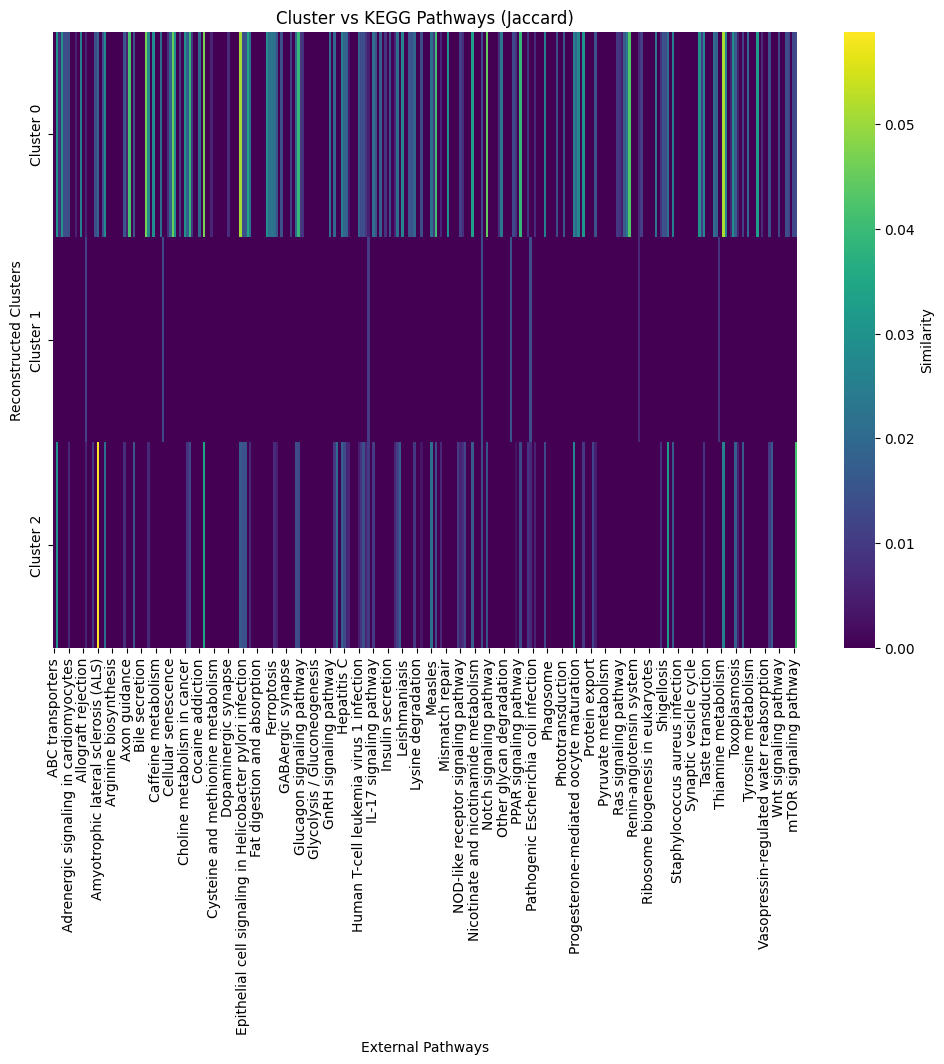

In [139]:
# Build Jaccard similarity matrix
sim_df = build_similarity_matrix(reconstructed, external_pathways, metric="jaccard")

# Plot heatmap
plot_similarity_heatmap(sim_df, title="Cluster vs KEGG Pathways (Jaccard)")

In [140]:
!pip install joblib scikit-learn pandas numpy torch torchvision

In [141]:
import joblib
import numpy as np
import pandas as pd
import torch

from sklearn.cluster import KMeans
from typing import Dict, Tuple, Any


In [142]:
def load_artifacts(kmeans_path: str, enrichment_path: str, model_path: str=None):
    """
    Load KMeans, enrichment_results and optionally a saved PyTorch model state.
    enrichment_results: expected format -> dict(cluster_id -> {"pathway": pathway_name, "p_value": pval})
    model_path: optional path to saved PyTorch model state_dict (if you saved whole model you may load differently)
    """
    kmeans = joblib.load(kmeans_path)
    enrichment_results = joblib.load(enrichment_path)
    model_state = None
    if model_path is not None:
        model_state = torch.load(model_path, map_location="cpu")
    return kmeans, enrichment_results, model_state

In [143]:
def encode_new_dataset(new_data, model, device="cpu"):
    """
    new_data: torch_geometric.data.Data with .x and .edge_index
    model: your trained model object (must have .encoder or forward that returns embeddings)
    Returns: numpy array (num_nodes, emb_dim)
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Accept either model.encoder or model directly (encoder returns node embeddings)
        if hasattr(model, "encoder"):
            z = model.encoder(new_data.x.to(device), new_data.edge_index.to(device))
        else:
            z = model(new_data.x.to(device), new_data.edge_index.to(device))
    return z.cpu().numpy()

In [144]:
def cluster_confidence(embeddings: np.ndarray, kmeans: KMeans) -> np.ndarray:
    """
    Returns confidence in [0,1] for each embedding -> 1 is highest confidence.
    We compute distance to assigned center and convert to a normalized confidence.
    """
    # distances to all cluster centers
    distances = kmeans.transform(embeddings)  # shape (n_samples, n_clusters)
    assigned_idx = kmeans.predict(embeddings)
    min_dist = distances[np.arange(distances.shape[0]), assigned_idx]  # distance to assigned center

    # Normalize: smaller distance => higher confidence
    # avoid division by zero
    max_d = np.maximum(min_dist.max(), 1e-8)
    conf = 1.0 - (min_dist / max_d)
    # Clip to [0,1]
    conf = np.clip(conf, 0.0, 1.0)
    return conf

In [145]:
def pathway_confidence_for_cluster(cluster_id: int,
                                   enrichment_results: Dict[int, Dict[str, Any]],
                                   scale_logmax: float = 10.0) -> Tuple[str, float]:
    """
    enrichment_results expected format:
        { cluster_id: {"pathway": pathway_name, "p_value": pval, ...}, ... }
    Returns (pathway_name, conf in [0,1]).
    scale_logmax: maximum -log10(p) that maps to confidence ~1.
        e.g., scale_logmax=10 => p=1e-10 -> conf ~ 1. p=1e-3 -> conf ~ 0.3.
    """
    default = ("Unknown", 0.0)
    if cluster_id not in enrichment_results:
        return default
    info = enrichment_results[cluster_id]
    pval = info.get("p_value", 1.0)
    pathway = info.get("pathway", info.get("pathway_name", "Unknown"))
    # handle edge cases
    if pval <= 0:
        pval = 1e-300
    logp = -np.log10(pval)
    conf = np.clip(logp / scale_logmax, 0.0, 1.0)
    return pathway, float(conf)

In [146]:
def classify_new_dataset_with_confidence(
    new_data,
    model,
    kmeans,
    enrichment_results,
    protein_ids,                # list of protein IDs in order matching new_data.x rows
    device="cpu",
    combined_threshold: float = 0.4,
    scale_logmax: float = 10.0
):
    """
    Returns a DataFrame with protein, assigned cluster, cluster_confidence,
    pathway (best mapped), pathway_confidence, combined_confidence, label.

    combined_confidence = cluster_confidence * pathway_confidence
    If combined_confidence < combined_threshold -> label "Uncertain"
    """
    # 1) Encode
    embeddings = encode_new_dataset(new_data, model, device)  # (n, d)

    # 2) Assign clusters with kmeans
    assigned_clusters = kmeans.predict(embeddings)

    # 3) Compute cluster confidence
    cl_conf = cluster_confidence(embeddings, kmeans)

    # 4) Map to pathway + pathway confidence per cluster
    pathway_names = []
    path_confs = []
    for c in assigned_clusters:
        pname, pconf = pathway_confidence_for_cluster(c, enrichment_results, scale_logmax=scale_logmax)
        pathway_names.append(pname)
        path_confs.append(pconf)

    path_confs = np.array(path_confs, dtype=float)

    # 5) Combined confidence
    combined_conf = cl_conf * path_confs

    # 6) Labeling
    labels = np.where(combined_conf >= combined_threshold, pathway_names, "Uncertain")

    # 7) Build DataFrame
    df = pd.DataFrame({
        "protein": protein_ids,
        "cluster": assigned_clusters,
        "cluster_confidence": cl_conf,
        "pathway": pathway_names,
        "pathway_confidence": path_confs,
        "combined_confidence": combined_conf,
        "label": labels
    })
    return df